In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

In [25]:
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3), # Делаем 3 канала
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set_id = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
test_loader_id = torch.utils.data.DataLoader(test_set_id, batch_size=BATCH_SIZE, shuffle=False)

test_set_ood = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
test_loader_ood = torch.utils.data.DataLoader(test_set_ood, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc_input_dim = 32 * 8 * 8 
        self.classifier = nn.Linear(self.fc_input_dim, 10)

    def forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc_input_dim)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [28]:
print("Training model...")
model.train()
for epoch in range(10): 
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
print("Training done.")


Training model...
Training done.


In [ ]:

def get_softmax_scores(model, loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(DEVICE)
            logits = model(images)
            probs = F.softmax(logits, dim=1)
            max_probs, _ = torch.max(probs, dim=1)
            scores.extend(max_probs.cpu().numpy())
    return np.array(scores)

def get_mcd_scores(model, loader, n_passes=20):
    model.train()
    scores = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(DEVICE)
            batch_probs = []
            for _ in range(n_passes):
                logits = model(images)
                batch_probs.append(F.softmax(logits, dim=1).unsqueeze(0))
            
            mean_probs = torch.cat(batch_probs, dim=0).mean(dim=0)
            max_probs, _ = torch.max(mean_probs, dim=1)
            scores.extend(max_probs.cpu().numpy())
    return np.array(scores)

def get_react_threshold(model, loader, percentile=90):
    model.eval()
    activations = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(DEVICE)
            feats = model.forward_features(images)
            activations.extend(feats.cpu().view(-1).numpy())
    
    threshold = np.percentile(activations, percentile)
    return threshold

def get_react_scores(model, loader, threshold):
    model.eval()
    scores = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(DEVICE)
            feats = model.forward_features(images)
    
            feats = feats.clamp(max=threshold)
            
            logits = model.classifier(feats)
            
            energy = torch.logsumexp(logits, dim=1)
            scores.extend(energy.cpu().numpy())
            
    return np.array(scores)


In [34]:

def calc_auroc(id_scores, ood_scores):
    y_true = np.concatenate([np.ones(len(id_scores)), np.zeros(len(ood_scores))])
    y_scores = np.concatenate([id_scores, ood_scores])
    return roc_auc_score(y_true, y_scores)

print("\nEvaluating Methods...")

print("1. Calculating Softmax...")
id_soft = get_softmax_scores(model, test_loader_id)
ood_soft = get_softmax_scores(model, test_loader_ood)
auc_soft = calc_auroc(id_soft, ood_soft)

print("2. Calculating MC Dropout...")
id_mcd = get_mcd_scores(model, test_loader_id)
ood_mcd = get_mcd_scores(model, test_loader_ood)
auc_mcd = calc_auroc(id_mcd, ood_mcd)

print("3. Calculating ReAct...")
clip_threshold = get_react_threshold(model, train_loader, percentile=90)

id_react = get_react_scores(model, test_loader_id, clip_threshold)
ood_react = get_react_scores(model, test_loader_ood, clip_threshold)
auc_react = calc_auroc(id_react, ood_react)

print("\n" + "="*30)
print("       RESULTS (AUROC)       ")
print("="*30)
print(f"Baseline Softmax : {auc_soft:.4f}")
print(f"MC Dropout       : {auc_mcd:.4f}")
print(f"ReAct            : {auc_react:.4f}")
print("="*30)



Evaluating Methods...
1. Calculating Softmax...
2. Calculating MC Dropout...
3. Calculating ReAct...

       RESULTS (AUROC)       
Baseline Softmax : 0.5542
MC Dropout       : 0.5924
ReAct            : 0.8205


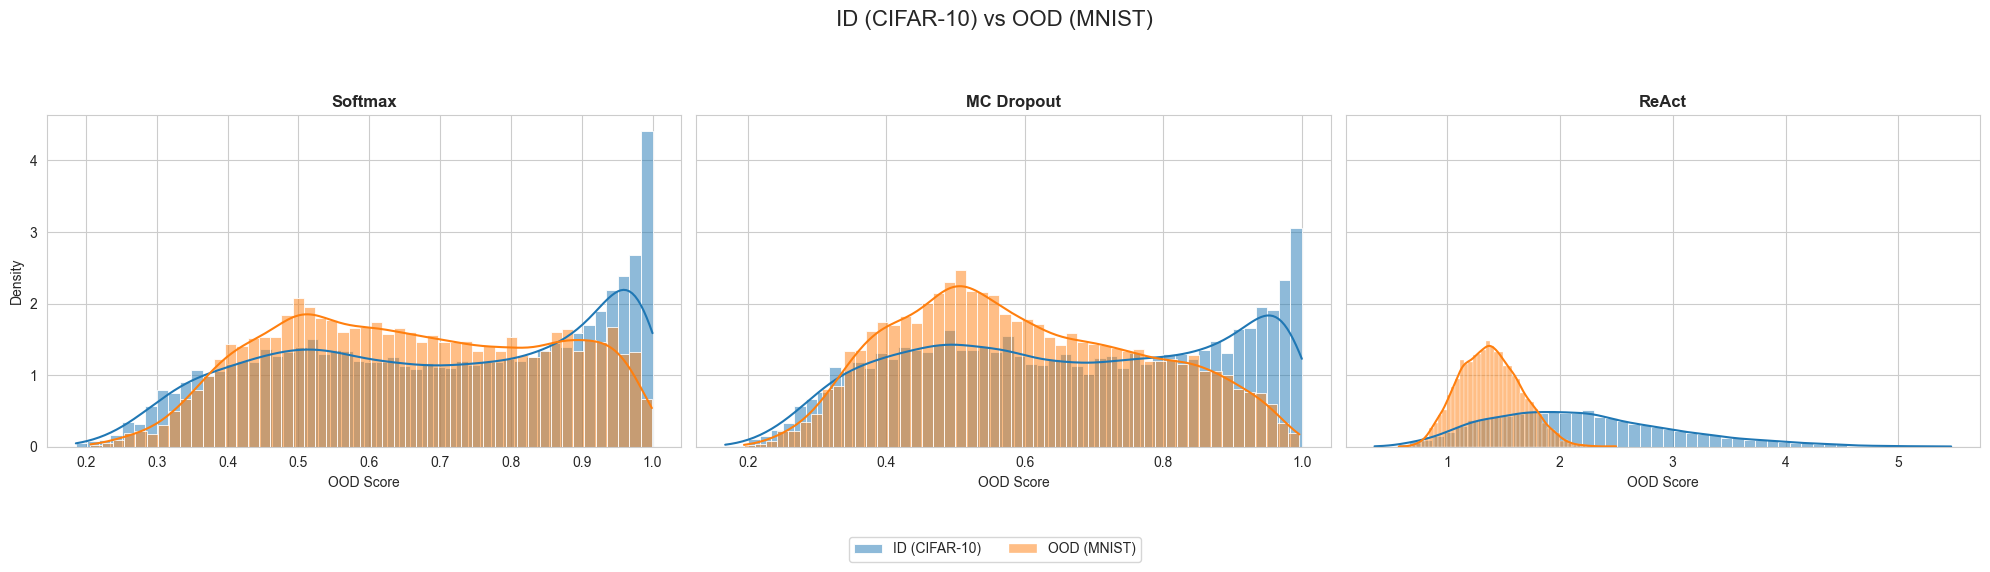

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('ID (CIFAR-10) vs OOD (MNIST)', fontsize=16, y=1.02)

methods = [
    ("Softmax", id_soft, ood_soft, "OOD Score"),
    ("MC Dropout", id_mcd, ood_mcd, "OOD Score"),
    ("ReAct", id_react, ood_react, "OOD Score")
]

colors = ['#1f77b4', '#ff7f0e']

for i, (name, id_scores, ood_scores, xlabel) in enumerate(methods):
    ax = axes[i]
    sns.histplot(id_scores, color=colors[0], label='ID (CIFAR-10)', kde=True, stat="density", bins=50, alpha=0.5, ax=ax)
    sns.histplot(ood_scores, color=colors[1], label='OOD (MNIST)', kde=True, stat="density", bins=50, alpha=0.5, ax=ax)
    
    ax.set_title(f"{name}", fontweight='bold')
    ax.set_xlabel(xlabel)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
